# Вам предстоит решать задачу классификации изображений методом логистической регрессии. 

В итоге вы должны получить  функцию $f(x) \to [0,1]^{10}$, которая на вход получает картинку с написанной от руки цифрой, а на выход дает 10 вероятностей от 0 до 1 принадлежности к каждому из классов (цифре). Картинка это вектор из (8*8) = 64 чисел. Мы будем рассматривать параметрическое семейство функций $F(c)$, таких,  что если $f_с \in F$, то она удовлетворяет нашим требованиям. Кроме того, для каждой функции  $f_c \in F$ мы можем посчитать, насколько она хорошо работает на некотором наборе картинок - это будет функционал качества этой функции $loss(f_c, images)$. Чем он меньше, тем лучше: в идеале $loss$ будет давать $0$ в том случае, если наша функция на всех картинках, на которых нарисована цифра $i$ выдала вектор, где все числа отличны от $1$ и только на $i-м$ месте стоит $1$. Иначе это будет некоторое положительное число, которое тем больше, чем хуже работает классификатор (потеря)

Итак, возьмем функцию $g(c) = loss(f_c, images)$ и будем ее минимизировать. Если мы найдем глобальный минимум, то научимся максимально качественно решать задачу классификации с помощью того семейства функций, которое мы выбрали. Глобальный минимум мы, конечно, не сможем аналитически найти, поэтому будем решать задачу минимизации методом градиентного спуска.

# Возьмем датасет нарисованных от руки картинок

In [3]:

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import math
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
import tqdm 

digits = load_digits()

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
digits.data.shape

(1797, 64)

# Пример содержимого датасета

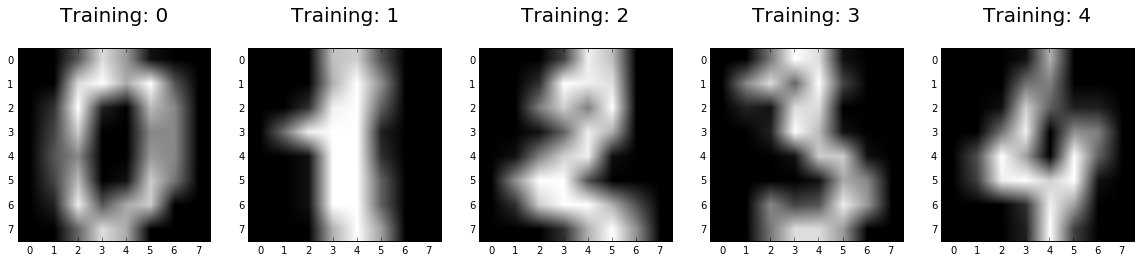

In [3]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

# Разделим датасет на 2 части - train и validate
1. На первой мы будем решать оптимизационную задачу - искать такую функцию, которая по картинке выдает правильную цифру. 
2. На второй будем независимо проверять, насколько качественно работает наша функция

Это необходимо для того, чтобы понимать, насколько наша функция реально умеет решать поставленную задачу: понимать, где какая цифра. У нас ограниченная выборка - всего 1797 картинок. Но в реальности нарисованных цифр может быть значительно больше! Если даже наша функция безошибочно работает на всех 1797 картинках, но ошибается вне - это плохо. Обычно график обучения должен выглядит примерно так, если зеленое - обучающая выборка, а красное - валидационная

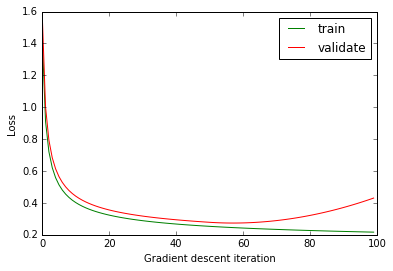

In [10]:
plt.plot(
    [1/math.log(i+2) for i in range(100)], 
    color='green', 
    label='train'
)

plt.plot(
    [1/math.log(i+2)*1.1+( (i/50.0-1)**2./5. if i>50 else 0.) for i in range(100)],
    color='red',
    label='validate')

plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

То есть с каждым шагом мы уменьшаем наш loss на обучающей выборке за счет градиентного спуска, но в какой-то момент функция может начать хорошо работать только на обучающей выборке. Этот эффект (в данном примере около 55 итерации по оси x) назвается переобучением.

# Вернемся к задаче
## Преобразуем числа от 0 до 9 в вектора из 10 элементов, где на i-m месте стоит 1, если цифра равна i и 0 иначе. 

## Также нормализуем картинки: все пиксели - это числа от 0 до 16. Сделаем их от -1 до 1, это улучшит качество нашей модели

In [4]:
def one_hot(y, n_classes):
    # делаем вектор из 10 координат с 0 везде кроме правильного ответа
    tmp = np.zeros(
        (len(y), n_classes), 
        dtype=np.uint8
    )
    tmp[range(len(tmp)), y] = 1
    return tmp

x_train, x_test, y_train, y_test = train_test_split(
    (digits.data-8)/16, 
    one_hot(digits.target,10),
    test_size=0.33, 
    random_state=0
)

# Задание: реализовать методом градиентного спуска логистическую регрессию. Начиная с этой ячейки и ниже разрешено использовать только стандартные функции  python и библиотеки numpy и  matplotlib

Для каждой картинки мы хотим найти вектор $(p_0,\ldots,p_{10})$, вероятностей, такой, что $p_i$ - вероятность того, что на картинка цифра $i$.

Реализуя логистическую регрессию, мы хотим приближать вероятности к их настоящему распределению. 

Выражение выдает ответ вида 
$$
A x + b
$$


где x - наш вектор картинки, а результат - числовой вектор размерности 10 с какими-то числами. Для того, чтобы эти числа стали вероятностями от 0 до 1, реализуем функцию 
$$
softmax(x) = \frac{e^x}{\sum(e^x)}
$$
и полученные значения будут как раз давать в сумме 1 и ими мы будем приближать вероятности. 

Оценивать качество нашей модели будем с помощью кросс-энтропии, см https://en.wikipedia.org/wiki/Cross_entropy 

In [5]:
def softmax(W,b,x):
    #todo - а можно ли написать лучше? и чем ваше решение лучше?
#     tmp = np.exp(np.dot(x,W.T)+b)
#     return (tmp.T/tmp.sum(axis=1)).T


# При взятии экспоненты могут получится значения,
# выходящие за пределы числового типа, чтобы избавиться от этого 
# сделаем следующее:

    tmp = np.dot(x, W) + b
    max_by_axis = np.max(tmp, axis=1, keepdims=True)
    tmp -= max_by_axis
    return np.exp(tmp)/np.sum(np.exp(tmp), axis=1, keepdims=True)

#todo - реализовать кросс-энтропию от предсказанного вектора pred и данного вектора y
def loss (y, pred):
    y = np.array(y)
    pred = np.array(pred)
    return -np.log(np.multiply(y, pred).sum(axis = 1)).sum()/y.shape[0]

# В данной точке x нужно научиться считать градиент. Выведите правила и посчитайте градиент в точке. Для того, чтобы выбирать градиент по всем точкам, можно его усреднить.

In [6]:
#todo - расчитать градиент 
def compute_gradients(out,y,x):
    M = np.multiply(out,y).sum()
    d = np.exp(-M)/(1+np.exp(-M))
    x = x.reshape((64,1))
    y = y.reshape((10,1))
    dW = x*y.T*d 
    db = y*d
    return (dW, db)

#усредняем по всем точкам
def gradients(W,b, x,y):
    sm = softmax(W,b,x)        
    e = [ compute_gradients(a,c,b) for a,c,b in zip(sm,y,x) ]                         
    dW_s = [i[0] for i in e]
    db_s = [i[1] for i in e]
    return np.mean(dW_s,axis=0), np.mean(db_s,axis=0).squeeze()   

# Методом градиентного спуска с постоянным шагом минимизируйте loss на обучающей выборке.

In [14]:
#todo - реализовать градиентный спуск

# функция, которую будем минимизировать:
def loss_function(y_pred, y): 
    M = -np.multiply(y,y_pred).sum(axis=1)
    return np.log(np.exp(M)+1).sum()/y.shape[0]

eta = 1

#todo - определить размерность параметров. Сколько их всего?
"""
Размерность именно такая, потому что мы берем картинку x - вектор из 64 чисел,
и произведя операции: W*x + b должны получить 10-мерный вектор вероятностей
"""
W = np.zeros((64, 10))
b = np.zeros(10)

#будем записывать потери на каждом шаге спуска
losses_train=[]
losses_valid=[]

losses_train_2=[]
losses_valid_2=[]

#собственно сам спуск
for i in tqdm.tqdm(range(5000)):
    dW, db = gradients(W,b, x_train, y_train)
    W += eta*dW
    b += eta*db
    
    train_pred = softmax(W,b,x_train)
    losses_train.append(loss(y_train,train_pred))
    losses_train_2.append(loss_function(y_train,train_pred))
    test_pred = softmax(W,b,x_test)
    losses_valid.append(loss(y_test,test_pred))
    losses_valid_2.append(loss_function(y_test,test_pred))
    
    if(i % 100 == 0):
        print('TrainLoss=', loss(y_train,train_pred))
        print('TestLoss=', loss(y_test,test_pred))
        print('\n')
        

  0%|          | 6/5000 [00:00<03:07, 26.58it/s]

TrainLoss= 2.20549191745
TestLoss= 2.21469773117




  2%|▏         | 108/5000 [00:03<02:23, 33.98it/s]

TrainLoss= 0.307562933016
TestLoss= 0.381855755496




  4%|▍         | 208/5000 [00:05<02:16, 35.15it/s]

TrainLoss= 0.34093496409
TestLoss= 0.440693208787




  6%|▌         | 308/5000 [00:08<02:14, 34.94it/s]

TrainLoss= 0.431441080817
TestLoss= 0.566990639778




  8%|▊         | 408/5000 [00:11<02:11, 34.84it/s]

TrainLoss= 0.534172250101
TestLoss= 0.708530482347




 10%|█         | 504/5000 [00:14<02:09, 34.69it/s]

TrainLoss= 0.641446306102
TestLoss= 0.856151657892




 12%|█▏        | 604/5000 [00:17<02:05, 34.97it/s]

TrainLoss= 0.750823273123
TestLoss= 1.00685211736




 14%|█▍        | 708/5000 [00:20<02:02, 34.94it/s]

TrainLoss= 0.861301186988
TestLoss= 1.15931990895




 16%|█▌        | 808/5000 [00:23<01:59, 34.98it/s]

TrainLoss= 0.97240673849
TestLoss= 1.31288699118




 18%|█▊        | 908/5000 [00:25<01:56, 35.16it/s]

TrainLoss= 1.08389404099
TestLoss= 1.46718015689




 20%|██        | 1008/5000 [00:28<01:52, 35.36it/s]

TrainLoss= 1.19562553169
TestLoss= 1.62197685724




 22%|██▏       | 1108/5000 [00:31<01:49, 35.47it/s]

TrainLoss= 1.30751930252
TestLoss= 1.77713734051




 24%|██▍       | 1208/5000 [00:33<01:46, 35.56it/s]

TrainLoss= 1.41952388344
TestLoss= 1.93256991666




 26%|██▌       | 1308/5000 [00:36<01:43, 35.66it/s]

TrainLoss= 1.5316054096
TestLoss= 2.08821209134




 28%|██▊       | 1404/5000 [00:39<01:41, 35.51it/s]

TrainLoss= 1.6437407462
TestLoss= 2.24401982936




 30%|███       | 1506/5000 [00:42<01:38, 35.42it/s]

TrainLoss= 1.75591362424
TestLoss= 2.39996119507




 32%|███▏      | 1605/5000 [00:45<01:36, 35.06it/s]

TrainLoss= 1.86811236267
TestLoss= 2.55601244578




 34%|███▍      | 1706/5000 [00:49<01:34, 34.70it/s]

TrainLoss= 1.98032845952
TestLoss= 2.71215554919




 36%|███▌      | 1804/5000 [00:52<01:32, 34.42it/s]

TrainLoss= 2.09255567898
TestLoss= 2.86837655469




 38%|███▊      | 1904/5000 [00:56<01:31, 33.97it/s]

TrainLoss= 2.20478943435
TestLoss= 3.02466449288




 40%|████      | 2005/5000 [00:59<01:28, 33.83it/s]

TrainLoss= 2.31702635575
TestLoss= 3.18101061183




 42%|████▏     | 2105/5000 [01:01<01:25, 33.97it/s]

TrainLoss= 2.42926397867
TestLoss= 3.33740783455




 44%|████▍     | 2205/5000 [01:04<01:21, 34.10it/s]

TrainLoss= 2.54150051493
TestLoss= 3.49385036554




 46%|████▌     | 2305/5000 [01:07<01:18, 34.18it/s]

TrainLoss= 2.65373468193
TestLoss= 3.65033340066




 48%|████▊     | 2405/5000 [01:10<01:15, 34.30it/s]

TrainLoss= 2.76596557417
TestLoss= 3.80685290997




 50%|█████     | 2505/5000 [01:12<01:12, 34.32it/s]

TrainLoss= 2.87819256614
TestLoss= 3.9634054734




 52%|█████▏    | 2605/5000 [01:15<01:09, 34.41it/s]

TrainLoss= 2.9904152389
TestLoss= 4.11998815524




 54%|█████▍    | 2707/5000 [01:18<01:06, 34.28it/s]

TrainLoss= 3.10263332456
TestLoss= 4.27659840749




 56%|█████▌    | 2807/5000 [01:21<01:03, 34.36it/s]

TrainLoss= 3.21484666438
TestLoss= 4.43323399521




 58%|█████▊    | 2907/5000 [01:24<01:00, 34.44it/s]

TrainLoss= 3.32705517747
TestLoss= 4.58989293836




 60%|██████    | 3007/5000 [01:27<00:57, 34.53it/s]

TrainLoss= 3.43925883737
TestLoss= 4.74657346663




 62%|██████▏   | 3107/5000 [01:29<00:54, 34.61it/s]

TrainLoss= 3.55145765484
TestLoss= 4.90327398397




 64%|██████▍   | 3207/5000 [01:32<00:51, 34.69it/s]

TrainLoss= 3.66365166525
TestLoss= 5.05999304087




 66%|██████▌   | 3307/5000 [01:35<00:48, 34.77it/s]

TrainLoss= 3.77584091946
TestLoss= 5.21672931252




 68%|██████▊   | 3407/5000 [01:37<00:45, 34.83it/s]

TrainLoss= 3.88802547743
TestLoss= 5.37348158155




 70%|███████   | 3507/5000 [01:40<00:42, 34.90it/s]

TrainLoss= 4.00020540369
TestLoss= 5.5302487243




 72%|███████▏  | 3607/5000 [01:43<00:39, 34.96it/s]

TrainLoss= 4.11238076432
TestLoss= 5.68702969983




 74%|███████▍  | 3707/5000 [01:45<00:36, 35.01it/s]

TrainLoss= 4.22455162499
TestLoss= 5.84382354103




 76%|███████▌  | 3807/5000 [01:48<00:34, 35.04it/s]

TrainLoss= 4.33671804974
TestLoss= 6.00062934734




 78%|███████▊  | 3907/5000 [01:51<00:31, 35.10it/s]

TrainLoss= 4.4488801003
TestLoss= 6.15744627871




 80%|████████  | 4007/5000 [01:54<00:28, 35.13it/s]

TrainLoss= 4.56103783574
TestLoss= 6.31427355053




 82%|████████▏ | 4107/5000 [01:56<00:25, 35.18it/s]

TrainLoss= 4.67319131245
TestLoss= 6.47111042923




 84%|████████▍ | 4207/5000 [01:59<00:22, 35.21it/s]

TrainLoss= 4.78534058418
TestLoss= 6.62795622849




 86%|████████▌ | 4307/5000 [02:02<00:19, 35.24it/s]

TrainLoss= 4.89748570223
TestLoss= 6.78481030589




 88%|████████▊ | 4407/5000 [02:04<00:16, 35.28it/s]

TrainLoss= 5.00962671565
TestLoss= 6.94167205991




 90%|█████████ | 4507/5000 [02:07<00:13, 35.32it/s]

TrainLoss= 5.12176367151
TestLoss= 7.09854092714




 92%|█████████▏| 4607/5000 [02:10<00:11, 35.34it/s]

TrainLoss= 5.23389661511
TestLoss= 7.2554163798




 94%|█████████▍| 4707/5000 [02:13<00:08, 35.39it/s]

TrainLoss= 5.3460255902
TestLoss= 7.41229792344




 96%|█████████▌| 4807/5000 [02:15<00:05, 35.43it/s]

TrainLoss= 5.45815063917
TestLoss= 7.56918509473




 98%|█████████▊| 4907/5000 [02:18<00:02, 35.45it/s]

TrainLoss= 5.57027180327
TestLoss= 7.72607745949




100%|██████████| 5000/5000 [02:20<00:00, 35.48it/s]


# Нарисуйте графики ошибки (loss) от номера шага градиентного спуска. Как падала ошибка на обучающей и тестовой выборках? На каком шаге ошибка на обучающей выборке оказалась минимальной?

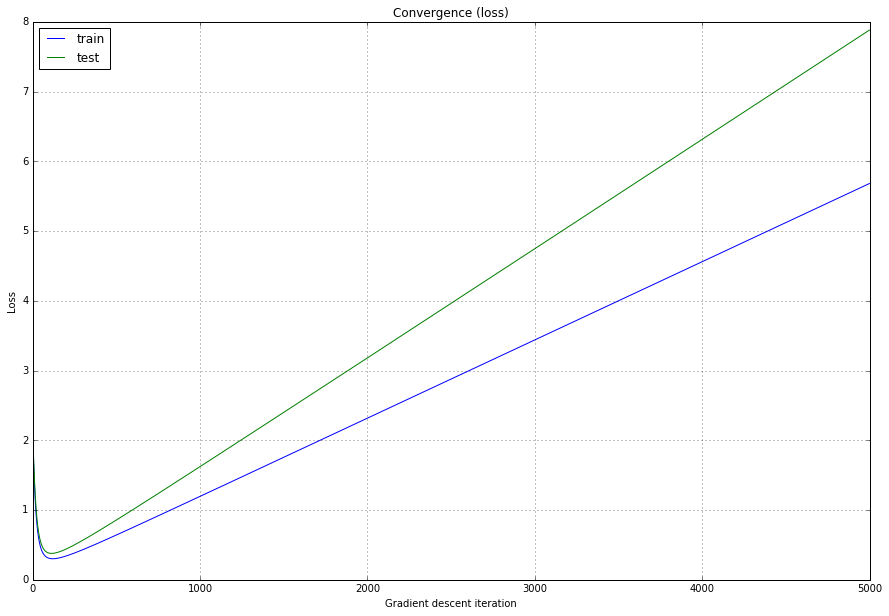

In [27]:
plt.figure(figsize=(15,10))
plt.plot(range(len(losses_train)), losses_train, label = 'train')
plt.plot(range(len(losses_valid)), losses_valid, label = 'test')
plt.title('Convergence (loss)')
plt.legend(loc = 'best')
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

Такое поведение графиков можно объяснить тем, что мы строим потери, используя одну метрику, а минимизируем другую. Если мы построим график ошибок той функции, которую минимизируем, то получим:

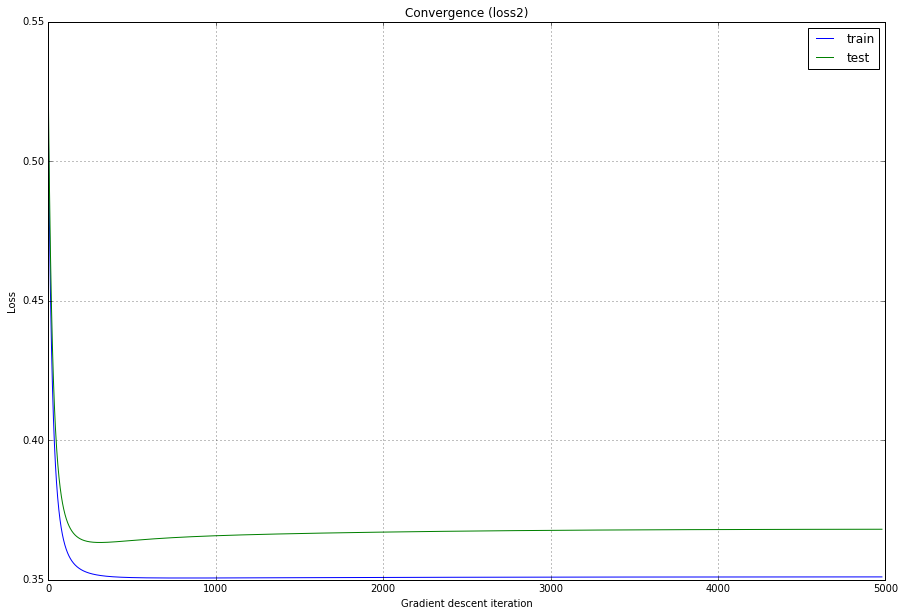

Минимальное значение на тесте на 328 шаге


In [28]:
plt.figure(figsize=(15,10))
plt.plot(range(len(losses_train)-20), losses_train_2[20:], label = 'train')
plt.plot(range(len(losses_valid)-20), losses_valid_2[20:], label = 'test')
plt.title('Convergence (loss2)')
plt.legend(loc = 'best')
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()
print('Минимальное значение на тесте на', np.argmin(losses_valid_2) ,'шаге',)

# Реализуйте выбор шага градиентного спуска методом Армихо. Ускорило ли использование метода Армихо с начальными параметрами
$$ s=100, \beta=\alpha=0.5$$
# достижение минимума на обучающей выборке по сравнению с фиксированным шагом 100? А на валидационной?

In [7]:
def armijo (W, b, x, y, dW, db, alpha=0.5, beta=0.5):
    s = 100
    condition = (loss_function(softmax(W + s*dW, b + s*db, x), y) > 
                 loss_function(softmax(W, b, x), y)+alpha*s*loss_function(softmax(dW, db, x), y))
    while condition:
        s *= beta
        condition = (loss_function(softmax(W + s*dW, b + s*db, x), y) > 
                     loss_function(softmax(W, b, x), y)+alpha*s*loss_function(softmax(dW, db, x), y))
    return s

# Какую долю картинок из валидационной выборки удается предсказать правильно? Приведите примеры из валидационной выборки, где модель ошибается и где работает правильно

In [29]:
y_pred = softmax(W, b, x_test)
results = (np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
print('Probability of correct prediction: ', np.mean(results))

Probability of correct prediction:  0.855218855219


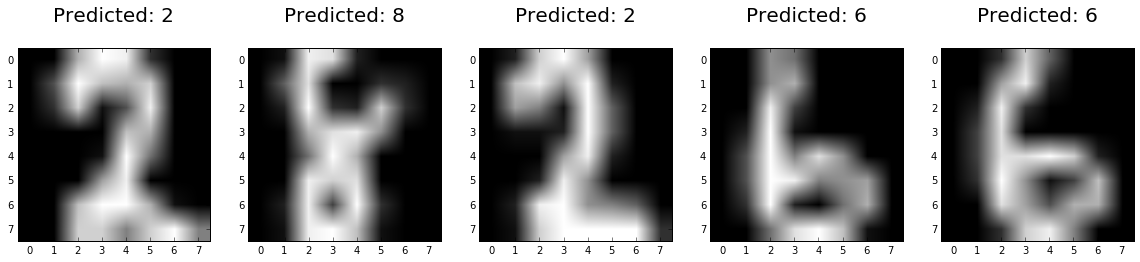

In [31]:
# Примеры цифр, предсказанных верно
plt.figure(figsize=(20,4))

index = 0
for i, v in enumerate(results):
    if v:
        plt.subplot(1, 5, index+1) 
        plt.imshow(np.reshape(x_test[i], (8,8)), cmap=plt.cm.gray)
        plt.title('Predicted: %i\n' % np.argmax(y_pred, axis=1)[i], fontsize = 20)
        index +=1
    if(index == 5):
        break

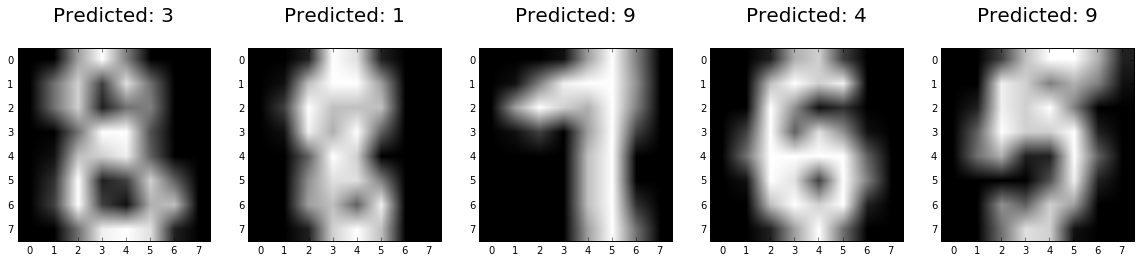

In [34]:
# Примеры цифр, предсказанных неверно
plt.figure(figsize=(20,4))

index = 0
for i, v in enumerate(results):
    if(v == False):
        plt.subplot(1, 5, index+1) 
        plt.imshow(np.reshape(x_test[i], (8,8)), cmap=plt.cm.gray)
        plt.title('Predicted: %i\n' % np.argmax(y_pred, axis=1)[i], fontsize = 20)
        index +=1
    if(index == 5):
        break

In [9]:
# Протестируем градиентыный спуск с правилом Армихо выбора шага:
def loss_function(y_pred, y): 
    M = -np.multiply(y,y_pred).sum(axis=1)
    return np.log(np.exp(M)+1).sum()/y.shape[0]

W = np.zeros((64, 10))
b = np.zeros(10)

#будем записывать потери на каждом шаге спуска
losses_train=[]
losses_valid=[]

losses_train_2=[]
losses_valid_2=[]

#собственно сам спуск
for i in tqdm.tqdm(range(5000)):
    dW, db = gradients(W,b, x_train, y_train)
    W += armijo(W, b, x_train, y_train, dW, db)*dW
    b += armijo(W, b, x_train, y_train, dW, db)*db
    
    train_pred = softmax(W,b,x_train)
    losses_train.append(loss(y_train,train_pred))
    losses_train_2.append(loss_function(y_train,train_pred))
    test_pred = softmax(W,b,x_test)
    losses_valid.append(loss(y_test,test_pred))
    losses_valid_2.append(loss_function(y_test,test_pred))
    
    if(i % 100 == 0):
        print('TrainLoss=', loss(y_train,train_pred))
        print('TestLoss=', loss(y_test,test_pred))
        print('\n')

  0%|          | 7/5000 [00:00<02:42, 30.82it/s]

TrainLoss= 1.09718420069
TestLoss= 1.40104866308




  2%|▏         | 105/5000 [00:03<02:43, 29.86it/s]

TrainLoss= 11.4942974789
TestLoss= 16.006302221




  4%|▍         | 205/5000 [00:06<02:36, 30.74it/s]

TrainLoss= inf
TestLoss= inf




  6%|▌         | 305/5000 [00:09<02:30, 31.23it/s]

TrainLoss= inf
TestLoss= inf




  7%|▋         | 345/5000 [00:11<02:28, 31.36it/s]

KeyboardInterrupt: 

  7%|▋         | 345/5000 [00:30<06:45, 11.49it/s]

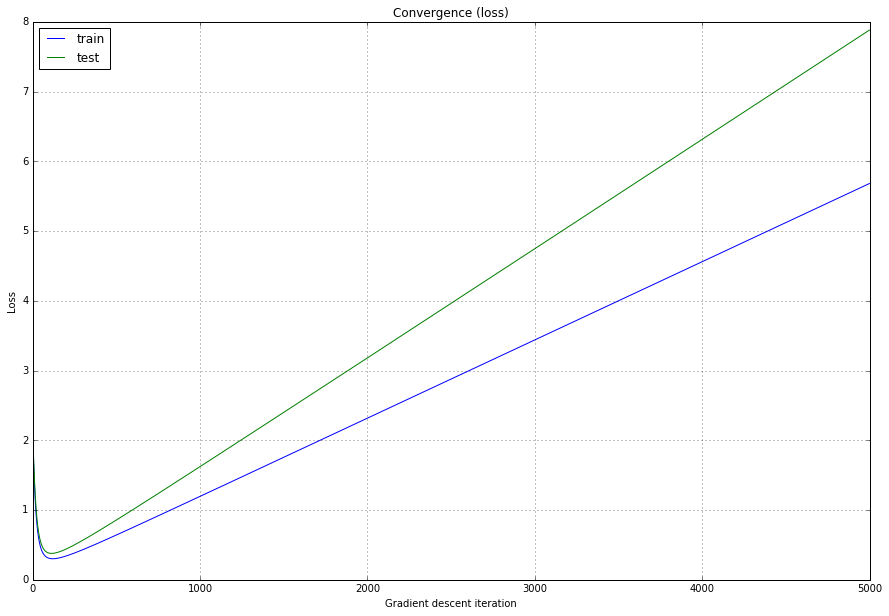

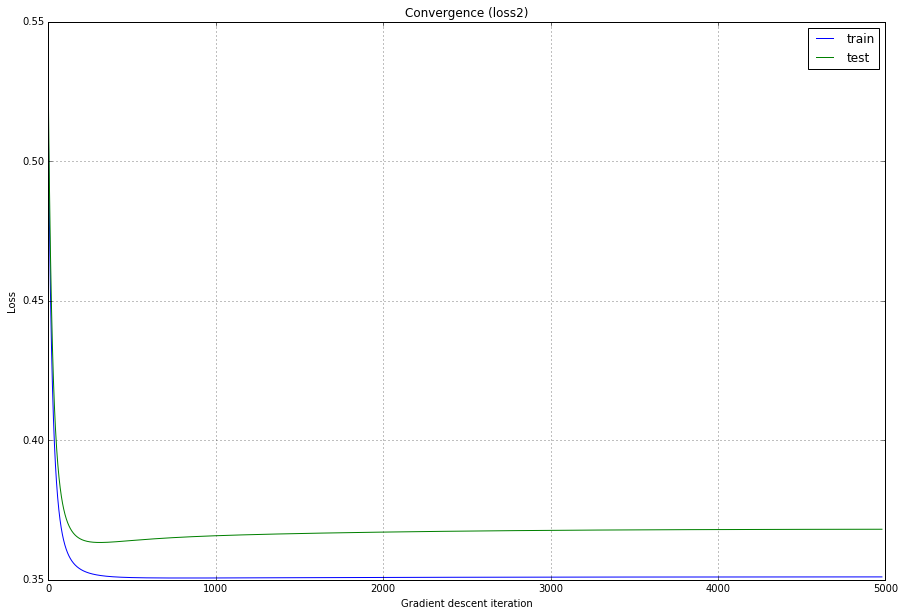

Минимальное значение на тесте на 328 шаге


In [79]:
plt.figure(figsize=(15,10))
plt.plot(range(len(losses_train)), losses_train, label = 'train')
plt.plot(range(len(losses_valid)), losses_valid, label = 'test')
plt.title('Convergence (loss)')
plt.legend(loc = 'best')
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.figure(figsize=(15,10))
plt.plot(range(len(losses_train)-20), losses_train_2[20:], label = 'train')
plt.plot(range(len(losses_valid)-20), losses_valid_2[20:], label = 'test')
plt.title('Convergence (loss2)')
plt.legend(loc = 'best')
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()
print('Минимальное значение на тесте на', np.argmin(losses_valid_2) ,'шаге',)